# Evidence for threshold selection

In [1]:
%matplotlib inline

import sys
import pickle
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import scipy.signal
from scipy import stats
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry

sys.path.append('/g/data/os22/chad_tmp/Aus_phenology/src')
from phenology_pixel_circular import _extract_peaks_troughs, xr_phenometrics

%load_ext autoreload
%autoreload 2

Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead


## Analysis Parameters


In [2]:
# k = 'Alice Tableland'
# k = 'Western Mallee'
# k='Simpson Desert'
k = 'Atarting'

ds_path = '/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022_0.2.0.nc'
ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'
var='SUB_NAME_7'

t = '2013', '2014'

## Open data

In [3]:
ds = assign_crs(xr.open_dataset(ds_path), crs='EPSG:4326')
ds = ds.rename({'AusENDVI_clim_MCD43A4':'NDVI'})
ds = ds['NDVI']

rain = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/rainfall_ANUClim_daily_5km_1960_2022.nc')['rain']
rain = assign_crs(rain.sel(time=slice(t[0], t[1])), crs='EPSG:4326')

#bare soil NDVI data
ss_path = f'/g/data/xc0/project/AusEFlux/data/ndvi_of_baresoil_5km.nc'
ss = assign_crs(xr.open_dataset(ss_path)['NDVI'], crs='epsg:4326')
ss.name = 'NDVI'

ds_8day = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/NDVI_mcd43a4_8day_2014_2020.nc')['NDVI']
ds_8day = assign_crs(ds_8day, 'epsg:4326')

## Clip to a region

In [4]:
gdf = gpd.read_file(ecoregions_file)
gdf = gdf[gdf[var]==k]

In [40]:
# gdf.explore()

In [5]:
#clip to ecoregion
geom = Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)
ds = ds.odc.mask(poly=geom)
ds = ds.dropna(dim='longitude', how='all').dropna(dim='latitude', how='all')
ds = ds.mean(['latitude', 'longitude'])

ds_8day = ds_8day.odc.mask(poly=geom)
ds_8day = ds_8day.dropna(dim='longitude', how='all').dropna(dim='latitude', how='all')
ds_8day = ds_8day.mean(['latitude', 'longitude'])

#mask soil ndvi
soil = ss.odc.mask(poly=geom)
soil = soil.mean().values.item()

#rainfall
rain = rain.odc.mask(poly=geom)
rain = rain.dropna(dim='longitude', how='all').dropna(dim='latitude', how='all')
rain = rain.mean(['latitude', 'longitude'])

## Smoothing filters

In [6]:
#resample before we smooth
ds_smooth = ds.resample(time="2W").interpolate("linear")

# # Savitsky-Golay smoothing
ds_smooth = xr.apply_ufunc(
        scipy.signal.savgol_filter,
        ds_smooth,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        kwargs=dict(
            window_length=11,
            polyorder=3,
            deriv=0,
            mode='interp'),
        dask='parallelized'
    )

# ds_trim = ds.sel(time=slice(t[0], t[1]))
ds_smooth_trim = ds_smooth.sel(time=slice(t[0], t[1]))

## Interpolation to daily

In [7]:
quad=ds_smooth_trim.dropna(dim='time', how='all').resample(time='1D').interpolate(kind='quadratic')

## Show peak/trough extraction

In [8]:
d={k:ds_smooth.dropna(dim='time', how='all').resample(time='1D').interpolate(kind='quadratic')}

In [9]:
peaks_troughs = _extract_peaks_troughs(d[k],
                                    rolling=90,
                                    distance=90,
                                    prominence='auto',
                                    plateau_size=10,
                                     )

## Extract phenometrics 

<!-- import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def double_logistic_function(t, wNDVI, mNDVI, S, A, mS, mA):
    sigmoid1 = 1 / (1 + np.exp(-mS * (t - S)))
    sigmoid2 = 1 / (1 + np.exp(mA * (t - A)))
    seasonal_term = sigmoid1 + sigmoid2 - 1
    return wNDVI + (mNDVI - wNDVI) * seasonal_term

def weight_function(t, S, A, r):
    tr = 100 * (t - S) / (A - S)
    tr = np.clip(tr, 0, 100)
    return np.exp(-np.abs(r) / (1 + tr / 10))

def fit_curve(t, ndvi_observed):
    initial_guess = [np.min(ndvi_observed), np.max(ndvi_observed), np.mean(t), np.mean(t), 1, 1]
    params, _ = curve_fit(double_logistic_function, t, ndvi_observed, p0=initial_guess, maxfev=10000)
    residuals = ndvi_observed - double_logistic_function(t, *params)
    weights = weight_function(t, params[2], params[3], residuals)
    params, _ = curve_fit(double_logistic_function, t, ndvi_observed, p0=initial_guess, sigma=weights, maxfev=10000)
    return params

doys = ndvi_cycle.time.dt.dayofyear.values[2:]
doys_frac = doys/365
values = ndvi_cycle.values[2:]

##Fit the curve
parameters = fit_curve(doys_frac, values)

##Plot the observed NDVI values
plt.scatter(doys, values, label='Observed NDVI')

##Generate points for the fitted curve
t_fit = np.linspace(min(doys_frac), max(doys_frac), 365)
ndvi_fit = double_logistic_function(t_fit, *parameters)

##Plot the fitted curve
plt.plot(t_fit*365, ndvi_fit, label='Fitted Curve', color='red')

plt.xlabel('Day of the Year')
plt.ylabel('NDVI')
plt.legend()
plt.title('Double Logistic Curve Fitting for NDVI Observations')
plt.show() -->


<!-- def xr_count_peaks(ds, order=16):
    def _find_peaks(ds):
        peaks = scipy.signal.argrelextrema(ds, np.greater, order=order)
        # peaks = scipy.signal.find_peaks(ds, height=0.2, distance=order)
        return len(peaks[0])
    
    ds_n_peaks = xr.apply_ufunc(_find_peaks,
                              ds, 
                              input_core_dims=[['time']],
                              vectorize=True, 
                              dask='parallelized',
                              output_dtypes=[np.float32]
                             )

    return ds_n_peaks.rename('n_peaks')

%%time
n_peaks = xr_count_peaks(ds_smooth.sel(time=slice('2004-09', '2006-03'))) -->

In [10]:
d={k: ds_smooth.dropna(dim='time', how='all').resample(time='1D').interpolate(kind='quadratic')}#.sel(time=slice('2009','2022'))}

phenometrics = xr_phenometrics(d[k].expand_dims(latitude=[-33.0],longitude=[135.0]),
                    rolling=90,
                    distance=90,
                    prominence='auto',
                    plateau_size=10,
                    amplitude=0.2,
                    soil_signal=soil,
                       ).compute()


phenometrics = phenometrics.squeeze().to_dataframe()

## Get daily GPP

In [11]:
flux = xr.open_dataset('https://dap.tern.org.au/thredds/dodsC/ecosystem_process/ozflux/AliceSpringsMulga/2022_v2/L6/default/AliceSpringsMulga_L6_Daily.nc')['GPP_SOLO']

flux  = xr.where(flux<0, 0, flux)

# Index NDVI at location and time so we have matching time series
lat,lon = flux.latitude, flux.longitude

# # Savitsky-Golay smoothing
flux = xr.apply_ufunc(
        scipy.signal.savgol_filter,
        flux,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        kwargs=dict(
            window_length=60,
            polyorder=3,
            deriv=0,
            mode='interp'),
        dask='parallelized'
    )



In [13]:
flux = flux.sel(time=slice(t[0], t[1]))

## Plot

In [14]:
phenometrics_trim = phenometrics[(phenometrics['EOS_year']>=2013) & (phenometrics['EOS_year']<=2014)]

In [15]:
_2013 = phenometrics_trim[phenometrics_trim['POS_year'] == 2013]

#calculate the ranges of values within one of the smaller seasons
b = pd.to_datetime(_2013.TOS.item()-1, unit='D', origin='2013')
e = pd.to_datetime(_2013.POS.item()-1, unit='D', origin='2013')

b_month = str(b)[0:7]+'-15'
e_month = str(e)[0:7]+'-15'

range_monthly = ds.sel(time=slice(b_month, e_month)).max().item() - ds.sel(time=slice(b_month, e_month)).min().item()
range_daily = d[k].sel(time=slice(b,e)).max().item() - d[k].sel(time=slice(b,e)).min().item()
rolling = d[k].rolling(time=90, min_periods=1, center=True).max()
range_rolling = rolling.sel(time=slice(b,e)).max().item() - rolling.sel(time=slice(b,e)).min().item()

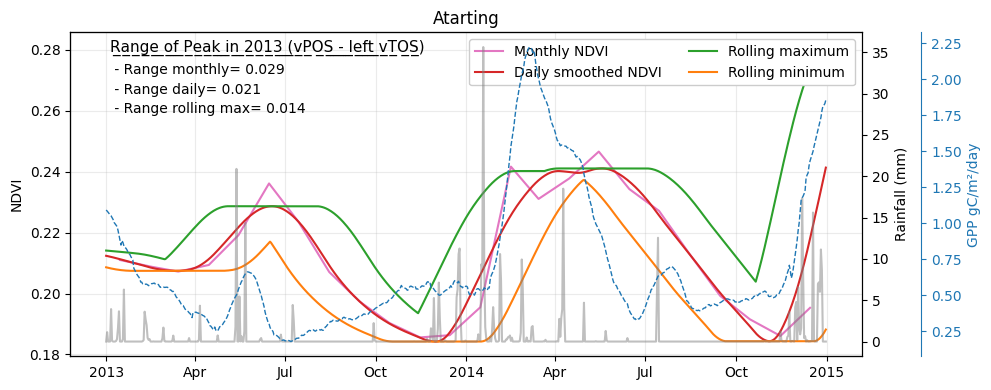

In [37]:
fig,ax=plt.subplots(1,1, figsize=(10,4))

ax2 = ax.twinx()
ax3 = ax.twinx()

ds.sel(time=slice(t[0], t[1])).plot(ax=ax, label='Monthly NDVI', zorder=5, c='tab:pink')

d[k].sel(time=slice(t[0], t[1])).plot(ax=ax, label='Daily smoothed NDVI', c='tab:red', zorder=5)
d[k].rolling(time=90, min_periods=1, center=True).max().sel(time=slice(t[0], t[1])).plot(ax=ax, label='Rolling maximum',c='tab:green', zorder=5)
d[k].rolling(time=90, min_periods=1, center=True).min().sel(time=slice(t[0], t[1])).plot(ax=ax, label='Rolling minimum', c='tab:orange', zorder=5)

ax.grid(alpha=0.25)
ax.set_title(k)
ax.set_xlabel(None)

rain.sel(time=slice(t[0], t[1])).plot(ax=ax2, zorder=-10, color='grey', alpha=0.5)
ax2.set_ylabel('Rainfall (mm)')
ax2.set_title(None)


flux.plot(ax=ax3, c='tab:blue', linestyle='--', linewidth=1.0, label='Daily GPP', zorder=-10)
ax3.spines['right'].set_position(('axes', 1.075))
ax3.spines['right'].set_color('tab:blue')
ax3.yaxis.label.set_color('tab:blue')
ax3.tick_params(axis='y', colors='tab:blue')
ax3.set_ylabel('GPP gC/m\N{SUPERSCRIPT TWO}/day')
ax3.set_title(None)

ax.text(.05, .94, "\u0332".join("Range of Peak in 2013 (vPOS - left vTOS)"),
            transform=ax.transAxes, fontsize=11)

ax.text(.05, .87, f' - Range monthly= {range_monthly:.3f}',
            transform=ax.transAxes, fontsize=10)

ax.text(.05, .81, f' - Range daily= {range_daily:.3f}',
            transform=ax.transAxes, fontsize=10)
ax.text(.05, .75, f' - Range rolling max= {range_rolling:.3f}',
            transform=ax.transAxes, fontsize=10)

ax.legend(ncols=2, loc='upper right', framealpha=1)
plt.tight_layout();

fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/Show_thresholds_{k}.png',
            bbox_inches='tight', dpi=300)

In [ ]:
# ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(phenometrics_trim.SOS.values, phenometrics_trim.SOS_year.values)],
#            y=phenometrics_trim.vSOS,
#           c='tab:green', label='SOS', zorder=10)

# ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(phenometrics_trim.EOS.values, phenometrics_trim.EOS_year.values)],
#            y=phenometrics_trim.vEOS,
#           c='tab:purple', label='EOS', zorder=10)

# ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(phenometrics_trim.POS.values, phenometrics_trim.POS_year.values)],
#                y=phenometrics_trim.vPOS,
#               c='black', label='POS', zorder=10)
    
# ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(phenometrics_trim.TOS.values, phenometrics_trim.TOS_year.values)],
#            y=phenometrics_trim.vTOS,
#           c='tab:orange', label='TOS', zorder=10)